## **Exercise 3: Tweetment Effect**

For this exercise, we will use regression to analyze a field experiment conducted on Twitter. This is based on the paper “[Tweetment Effects on the Tweeted: Experimentally Reducing Racist Harassment](https://link.springer.com/article/10.1007%2Fs11109-016-9373-5#Sec25)” by Kevin Munger.

Professor Munger identified accounts on Twitter that posted racist tweets. He then randomized these accounts to a control group or one of four possible treatment arms. The accounts in the treatment arms received responses to their racist tweets of the following form:

![](https://raw.githubusercontent.com/SnehaEkka/causal-inference/main/03-tweetment-effects-experiment/tweet_image.png "Tweet")

The four arms differed in the characteristics of the responder, namely number of followers and in their in-group vs out-group status.

![](https://raw.githubusercontent.com/SnehaEkka/causal-inference/main/03-tweetment-effects-experiment/treatment_arms.png "Treatment Arms")

**Varible Definitions**

| Variable          | Variable Definitions for tweetment_effect.csv                                                                                                                               |
|-------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `treatment_arm`   | There are four treatments (1 - 4) and a control (0).                                                                                                                      |
| `any_treatment`   | Did the subject receive any of the treatments? (1 = yes, 0 = no)                                                                                                          |
| `anonymity`       | Was the twitter account anonymous? ranged from 2  (most anonymous) to 0 (least anonymous)." Assume this relates to the racist account. Measured prior to experiment. |
| `log.followers`   | Log of the number of followers of the responding account.                                                  |
| `racism.scores.pre.2mon` | Measure of how racist the account was in the 2 months before experiment.                                                                                                   |
| `racism.scores.post.2mon` | Measure of how racist the account was in the 2 months after experiment.                                                                                                    |
| `racism.scores.post.1mon` | Measure of how racist the account was in the 1 month after experiment.                                                                                                     |


In [ ]:
# Necessary data cleaning, do not touch.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules and functions

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 8)})

from statsmodels.stats.weightstats import ttest_ind # for t-test

# read data

tweets_data = pd.read_csv('tweetment_effect.csv')

# Drop columns X.1, X, and V1
tweets_data.drop(columns=['X.1', 'X'], inplace=True)

# Rename the column 'treat.f' to 'treatment_arm'
tweets_data.rename(columns={'treat.f': 'treatment_arm'}, inplace=True)

# Drop the 'In_group' column
tweets_data.drop(columns='In_group', inplace=True)

# Drop the 'high_followers' column
tweets_data.drop(columns='high_followers', inplace=True)

# Create a new column 'any_treatment' as a numeric representation of 'treatment_arm != 0'
tweets_data['any_treatment'] = (tweets_data['treatment_arm'] > 0).astype(int)

# Drop the 'racism.scores.post.1wk' and 'racism.scores.post.2wk' columns
tweets_data.drop(columns=['racism.scores.post.1wk', 'racism.scores.post.2wk'], inplace=True)

# Convert 'treatment_arm' column to a factor
tweets_data['treatment_arm'] = tweets_data['treatment_arm'].astype('category')
tweets_data.columns = [col.replace(' ', '_').replace('.', '_').replace('-', '_') for col in tweets_data.columns]

tweets_data.head()

,Unnamed:_0,treatment_arm,anonymity,log_followers,racism_scores_pre_2mon,racism_scores_post_2mon,racism_scores_post_1mon,any_treatment
0,1,4,1,4.094345,0.000000,0.225806,0.451613,1
1,2,4,2,7.007601,0.048387,0.177419,0.193548,1
2,3,4,2,6.948897,0.016129,0.000000,0.000000,1
3,4,2,2,8.270781,0.032258,0.225806,0.129032,1
4,5,2,1,5.411646,0.016129,0.064516,0.129032,1


In [ ]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Linear Regression (lm)
lm_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment', data=tweets_data).fit()

# Robust Fixed Effects OLS (feols) with White Standard Errors
feols_robust_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment', data=tweets_data).fit(cov_type='HC3')

Stargazer([lm_model, feols_robust_model])


####  Q1.1: Of the above variables (in the dataset), please identify all variables above that may be ‘good’ control variables in a regression where the outcome is ‘racism.scores.post.2mon’ and the regressor is ‘any_treatment’?

In [ ]:
# Robust Fixed Effects OLS (feols) with White Standard Errors
anonymity_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment + anonymity', data=tweets_data).fit(cov_type='HC3')
logfoll_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment + log_followers', data=tweets_data).fit(cov_type='HC3')
pre2mon_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment + racism_scores_pre_2mon', data=tweets_data).fit(cov_type='HC3')

Stargazer([feols_robust_model, anonymity_model, logfoll_model, pre2mon_model])

**Answer 1.1**

The variables `anonymity` and `log_followers` could be considered good control variables in a regression where the outcome is `racism_scores_post_2mon` and the regressor is `any_treatment`. This assessment is based on the observation that including these variables in the regression does not significantly alter the coefficient of the variable of interest, `any_treatment`, while only causing minor changes in the standard deviation. In contrast, `racism_scores_pre_2mon` appears to significantly impact the coefficient of "any_treatment," which may not be desirable for controlling the effects of the treatment variable.

#### Q1.2: Run a regression of ‘racism.scores.post.2mon’ on ‘any_treatment’. What do we learn from this regression about the effect of the treatment? Please explain in words in addition to just returning the number.

In [ ]:
# Linear Regression

lr_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment', data=tweets_data).fit(cov_type='HC3')
Stargazer([lr_model])

**Answer 1.2**

The regression model of `racism_scores_post_2mon` on `any_treatment` reveals a coefficient of -0.083 for the treatment effect. This indicates that the treatment has a negative effect on the racism score post 2 months, suggesting a reduction in racism scores by a coefficient of 0.083. However, it's important to note that this effect does not appear to be statistically significant, as indicated by the p-value being > 0.05.

#### Q1.3: Add the variable(s) from a) as controls into the regression from b). What happens to our estimate of the effect of the treatment and its standard error?

In [ ]:
covariate_model = sm.OLS.from_formula('racism_scores_post_2mon ~ any_treatment + anonymity + log_followers',
                                      data=tweets_data).fit(cov_type='HC3')
Stargazer([lr_model, covariate_model])

**Answer 1.3**

After adding `anonymity` as a control variable into the regression model of `racism_scores_post_2mon` on `any_treatment`, the estimate of the treatment effect changes minimally from -0.083 to -0.082, and the standard error remains largely unchanged.

####  Q1.4: Use a regression to check for differences between the treatment and control for one of the variables identified in a). Also use the proportions_ztest function to check whether the randomization proportion was intended. Based on these results, should we be concerned that the randomization was done improperly?

__Note: Each arm of the experiment was assigned with equal probability and there are 4 treatment arms and one control.__


In [ ]:
# Regression to check for differences b/w treatment and control groups pre-experiment
trt = tweets_data[tweets_data['any_treatment']==1]
ctr = tweets_data[tweets_data['any_treatment']==0]

pre_model_trt = sm.OLS.from_formula('racism_scores_pre_2mon ~ anonymity', data=trt).fit(cov_type='HC3')
pre_model_ctr = sm.OLS.from_formula('racism_scores_pre_2mon ~ anonymity', data=ctr).fit(cov_type='HC3')

Stargazer([pre_model_trt, pre_model_ctr])

In [ ]:
# Proportions z-test
from statsmodels.stats.proportion import proportions_ztest

count = len(tweets_data[tweets_data['any_treatment']==1])
nobs = len(tweets_data)
value = 0.8
stat, pval = proportions_ztest(count, nobs, value)
print('{0:0.3f}'.format(pval))

0.595


**Answer 1.4**

- The regression results indicate that there are no statistically significant differences between the treatment and control groups concerning the variable `racism_scores_pre_2mon` and `anonymity`. This suggests that pre-experiment conditions were similar across both groups for these variables.
- The proportion z-test reveals that the intended randomization was achieved, as the p-value exceeds 0.05. Therefore, we fail to reject the null hypothesis that the desired and achieved proportions are the same.

In conclusion, there is no indication that the randomization was done improperly, as both the pre-experiment observable characteristics and the achieved proportion of treatment and control arms align with the intended design of the experiment.

#### Q1.5: We would like to know whether treatment arm 2 or treatment arm 3 is statistically significantly better at reducing racist behavior. Perform a t test or regression and test for the null hypothesis that treatment arm 2 has the same effect as treatment arm 3.


In [ ]:
tstat, pvalue, df = ttest_ind(tweets_data.loc[tweets_data['treatment_arm'] == 2, 'racism_scores_post_2mon'],
                              tweets_data.loc[tweets_data['treatment_arm'] == 3, 'racism_scores_post_2mon'],
                              alternative = 'two-sided', usevar = 'unequal')

print(f"t-score (t): {tstat}")
print(f"P-value (p): {pvalue}")

t-score (t): 1.6245928260821811
P-value (p): 0.10912360652396604


**Answer 1.5**

An independent t-test between treatment arms 2 and 3 using the post 2 months racism scores results in a p-value of 0.109 (> 0.05) indicates that we fail to reject the null hypothesis, suggesting that treatment arm 2 does not have a statistically significant different effect from treatment arm 3 in reducing racist behavior.

#### Q1.6: Plot the mean of `racism.scores.post.2mon` by treatment arm. Make it look nice and readable, while helping the reader understand the differences between arms.

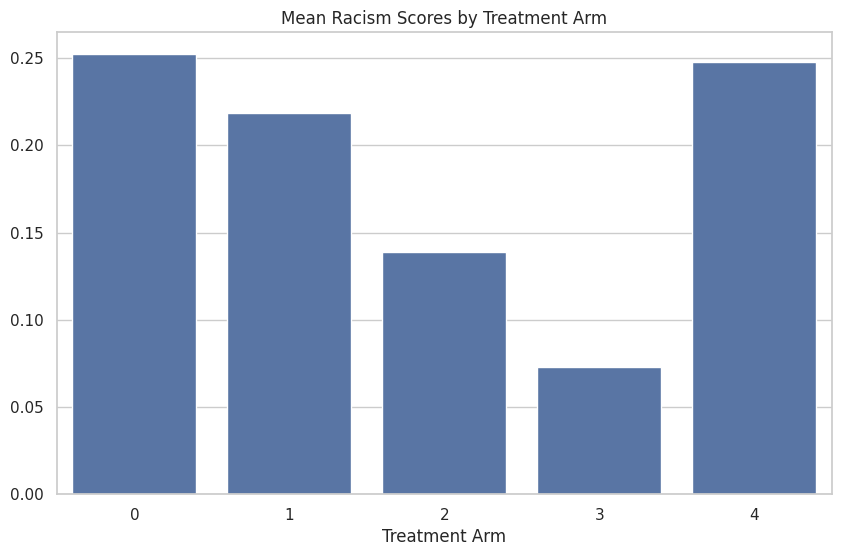

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

treatment_arms = [0, 1, 2, 3, 4]
treatment_arms_mean = np.array(tweets_data.groupby(by=['treatment_arm'])['racism_scores_post_2mon'].mean())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=treatment_arms, y=treatment_arms_mean)
plt.xlabel('Treatment Arm')
plt.title('Mean Racism Scores by Treatment Arm')
plt.show();

### **Q2. Stubhub Price Salience Experiment (50 Points)**

This set of questions and case is based on “(Price Salience and Product Choice)[http://faculty.haas.berkeley.edu/stadelis/AIP.pdf]” by Blake et al.
Please read only pages 1 - 3 (ending at ‘Reassuringly, the results are broadly consistent with our findings from the 2015 experiment, indicating that this concern is not first-order in our setting.’) and the pasted text below, starting with "Experimental Design".

![](paper_screenshot.png "Experiment")

The authors also tested whether the treatment and control groups were similar on characteristics observed prior to the treatment assignment. They say:  

![](balance_check.png "Balance")

This table displays the treatment effects in percent terms, as well as the standard errors in percent terms, which are displayed in parentheses.

![](effects_table.png "Effects")


### 2.1 Experiment Description

Describe the treatment in the first experiment and the unit of randomization, be very precise here. What share was randomized to the treatment?
- This refers to the experiment conducted in August 2015, the first experiment described in the introduction of the paper.


**Answer 2.1**

The treatment in the first experiment conducted by StubHub in August 2015 involved implementing a back-end-fee (BF) strategy, where mandatory fees were only shown to consumers after they had selected a particular ticket and proceeded to the checkout page. The unit of randomization was individual U.S. users of the StubHub platform. Specifically, StubHub randomly selected 50% of U.S. users to experience the BF strategy, while the remaining 50% were assigned to the upfront-fee (UF) strategy. This means that the share randomized to the treatment (BF experience) was 50%, with the remaining 50% serving as the control group (UF experience).


### 2.2 Randomization Check

Table II displays a randomization / balance check. A randomization check is a regression where the dependent variable occurs before the experiment. It should be very unlikely that there are substantial differences in before experiment variables if the experiment was done properly. Suggest a variable not used by the authors that would be appropriate to include in a balance check.
- Hint: consider whether your proposed variable is measured before the treatment happens or after the treatment happens.


**Answer 2.2**

Including users' purchase order history pre-experiment as a variable in the balance check would ensure comparability between the treatment and control groups. This variable reflects past behavior and preferences, influencing responses to the treatment. Its inclusion helps identify potential issues with randomization. Therefore, incorporating purchase order history might possibly enhance the assessment of randomization success and group comparability.


### 2.3 Treatment Effect on Propensity to Purchase

What is the effect of the treatment on the Propensity to Purchase at least one product? Calculate the 95% confidence interval for this estimate.


**Answer 2.3**

The effect of the treatment on the Propensity to Purchase at least one product (as seen in Table 3) is found to be 14.1 which indicates that the treatment increases the likelihood of a purchase by 14.1%.

In [ ]:
# 95% confidence interval for this estimate

estimate = 14.1
standard_err = 0.09
lower_lim = np.round(estimate - 1.96*standard_err, 3)
upper_lim = np.round(estimate + 1.96*standard_err, 3)

print("95% Confidence Interval for the estimate of treatment effect on Propensity to Purchase (14.1%) is: [",lower_lim,",",upper_lim,"]")

95% Confidence Interval for the estimate of treatment effect on Propensity to Purchase (14.1%) is: [ 13.924 , 14.276 ]


The above confidence interval states that we can be sure of the estimate of the treatment effect 95% of the times. We can be sure of this also because the confidence interval does not include zero and the standard error for this estimate is very small.


### 2.4 Randomization by City

Suppose the authors randomized by city of the event. Name one benefit that may occur as a result of this randomization strategy and one harm.


**Answer 2.4**

- **Benefit:** Randomizing by city may allow for controlling regional factors that influence consumer behavior. By ensuring representation across diverse cities, we could mitigate the impact of local demographics, cultural norms, and economic conditions on study outcomes. This could enhance the study's internal validity by providing a more accurate assessment of the treatment's effects across different geographic areas.
- **Harm:** Randomizing by city may lead to variations in the type and number of events across cities. Cities with more events could attract more buyers, potentially influencing purchase decisions differently compared to cities with fewer events. This variability in event characteristics may confound the effects of the treatment, making it difficult to isolate its true impact on consumer behavior. Therefore, one potential harm of randomizing by city is the uneven distribution of event characteristics, which could introduce bias and affect the validity of the study's conclusions.


### 2.5 Product Manager Recommendation

Suppose that you are the product manager for the monetization team at Stubhub. Based on the evidence presented above, would you launch the treatment to the entire site? The answer should be 1 paragraph. It should consist of an answer (yes, no), and two pieces of evidence relating to that recommendation. Case participation will also constitute part of this grade.

**Answer 2.5**

Yes! I would recommend launching the treatment to the entire site based on compelling evidence of its positive impact. Firstly, the substantial 18.96% increase in cookie session revenue with back-end fees compared to the upfront fee strategy provides a robust economic justification for scaling up the treatment. This financial gain underscores the effectiveness of the approach in driving revenue growth. Additionally, the statistically significant 14.1% rise in the propensity to make a purchase under the treatment further validates its efficacy in influencing consumer behavior positively. These consistent and significant improvements in both revenue and purchase likelihood indicate the treatment's potential for widespread and enduring positive effects on user engagement and monetization.